In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch as th

from cnn import CNN, createLossAndOptimizer
from torch.utils.data import DataLoader
from tqdm import tqdm

from imgdata import DefaultTrainSet

In [2]:
%matplotlib inline

if th.cuda.is_available():
  # Make CuDNN Determinist
  th.backends.cudnn.deterministic = True

# Define default device, we should use the GPU (cuda) if available
device = th.device("cuda" if th.cuda.is_available() else "cpu")
device

device(type='cpu')

### Set Constants
define learning rate as a list of values, and the number of epochs and batch size

In [3]:
learning_rates = [1e-2, 1e-3, 1e-4, 1e-5]
batch_size = 16
num_epochs = 20

### Load data
using the DefaultTrainSet class from imgdata.py

In [4]:
train_set = DefaultTrainSet()

train_dataloader = th.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)

### Define the training function

In [5]:
def train(net, batch, n_epochs, lr, train_loader):
    """
    Train a neural network and print statistics of the training

    :param train_loader: loader for the training data
    :param net: (PyTorch Neural Network)
    :param batch: (int)
    :param n_epochs: (int)  Number of iterations on the training set
    :param lr: (float) learning rate used by the optimizer
    """
    print("---------- HYPERPARAMETERS ----------")
    print("batch_size=", batch)
    print("n_epochs=", n_epochs)
    print("learning_rate=", lr)
    print("-" * 40)
    accuracies = []
    losses = []
    criterion, optimizer = createLossAndOptimizer(net, lr)
    # Move model to gpu if possible
    net = net.to(device)
    for epoch_count, epoch in enumerate(range(n_epochs)):
        # Set the model to training mode
        net.train()
        # Initialize the variables to compute the average loss
        total_loss = 0.00
        avg_loss = 0.00
        total_correct = 0
        pbar = tqdm(train_loader, leave=False)
        # Iterate over the training set
        for i, data in enumerate(pbar):

            # Get the inputs
            inputs, labels = data['imNorm'], data['label']
            # Move them to the correct device
            inputs = inputs.to(device)
            labels = labels.to(device)
            net = net.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = net(inputs)
             # Calculate Loss: softmax --> cross entropy loss
            loss = criterion(outputs, labels)
            
            _, preds = th.max(outputs, 1)

            # Getting gradients w.r.t. parameters
            loss.backward()

            # Updating parameters
            optimizer.step()

            # Update the running variables
            total_loss += loss.item()
            avg_loss = total_loss / (i + 1)
            total_correct += th.sum(preds == labels.data)
            pbar.set_description("Epoch: {}/{}".format(epoch_count + 1, n_epochs))
            pbar.set_postfix(avergae_loss=avg_loss, running_accuracy=th.sum(preds == labels).item() / float(labels.size(0)))
            # save the model
            model_name = f"Outputs/models/model_{num_epochs}_epochs_learning_rate_{lr}.pth"
            th.save(net.state_dict(), model_name)

        # Calculate the average loss and accuracy of the epoch
        losses.append(total_loss/len(train_loader))
        accuracies.append((total_correct/train_loader.sampler.num_samples).item())
        # print losses and accuracies in the last epoch
        if epoch_count == n_epochs - 1:
            print("---------- FINAL RESULTS ----------")
            print("Losses fot every epoch:", losses)
            print("Average accuracy for each epoch: {}".format(accuracies))
            print("-" * 40)
    return losses, accuracies

In [6]:
losses_list = []
accuracies_list = []
for learning_rate in learning_rates:
    cnn = CNN()
    print("Training with learning rate {}\n".format(learning_rate))
    loss, accu = train(cnn, batch_size, n_epochs=num_epochs, lr=learning_rate, train_loader=train_dataloader)
    losses_list.append(loss)
    accuracies_list.append(accu)
    print("-"*40)

Training with learning rate 0.01

---------- HYPERPARAMETERS ----------
batch_size= 16
n_epochs= 20
learning_rate= 0.01
----------------------------------------


---------- FINAL RESULTS ----------
Losses fot every epoch: [104.96033334732056, 25.165923313661054, 7.954259493134239, 3.850940493019891, 7.652617286683711, 3.3344720036202484, 2.1864193385110764, 1.6461640666557324, 1.2962812190137176, 1.6930648408059759, 0.800819075785986, 0.45968495888714433, 0.5423279638606057, 0.6897547839014971, 1.0628870557650265, 0.6200065025213071, 0.34914616128785075, 0.4216768116846042, 0.31602704144072563, 2.682159618446049e-07]
Average accuracy for each epoch: [0.43714284896850586, 0.6828571557998657, 0.7771428823471069, 0.854285717010498, 0.831428587436676, 0.8885714411735535, 0.8942857384681702, 0.9142857193946838, 0.9457142949104309, 0.954285740852356, 0.9599999785423279, 0.9714285731315613, 0.9685714244842529, 0.9571428298950195, 0.954285740852356, 0.977142870426178, 0.9857142567634583, 0.977142870426178, 0.9828571677207947, 1.0]
----------------------------------------
----------------------------------------
Training with learning rate 0.001

------

---------- FINAL RESULTS ----------
Losses fot every epoch: [12.920003002340144, 2.9581039409544743, 0.9101594215555285, 0.5026930858359926, 0.8778183410071175, 0.5591610752369227, 0.32047017826500285, 0.2107770241726195, 0.3681904586760952, 0.22645918471217835, 0.2478557192217853, 0.1329798554068227, 0.1273177160577118, 0.10634908141678324, 0.45398322635649246, 0.8248824364611628, 0.1851118872695767, 0.12695107332498515, 0.1889187481631735, 0.2554784416606914]
Average accuracy for each epoch: [0.43714284896850586, 0.7285714149475098, 0.8714285492897034, 0.8971428275108337, 0.8914285898208618, 0.9171428680419922, 0.9399999976158142, 0.9485714435577393, 0.9428571462631226, 0.9514285922050476, 0.9685714244842529, 0.9685714244842529, 0.9800000190734863, 0.9742857217788696, 0.9428571462631226, 0.9285714030265808, 0.977142870426178, 0.9714285731315613, 0.9628571271896362, 0.9685714244842529]
----------------------------------------
----------------------------------------
Training with lear

---------- FINAL RESULTS ----------
Losses fot every epoch: [1.7346258014440536, 0.5729859105565331, 0.24399793215773322, 0.14236373877660793, 0.0772657533260909, 0.04818858790465377, 0.031218154228885065, 0.025364421752535483, 0.02060243110595779, 0.019464279800145465, 0.014026526128873229, 0.011398585492067716, 0.010941669810563326, 0.008306732485917482, 0.007943184781734917, 0.007253446531566707, 0.006313255003822798, 0.006717388465238566, 0.005019770892844958, 0.0051267908949574285]
Average accuracy for each epoch: [0.488571435213089, 0.8285714387893677, 0.9257143139839172, 0.9599999785423279, 0.9942857027053833, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
----------------------------------------
----------------------------------------
Training with learning rate 1e-05

---------- HYPERPARAMETERS ----------
batch_size= 16
n_epochs= 20
learning_rate= 1e-05
----------------------------------------


---------- FINAL RESULTS ----------
Losses fot every epoch: [1.3823573101650586, 0.8938782567327673, 0.6868058361790397, 0.5696391300721602, 0.4792024669322101, 0.4258406419645656, 0.3734537051482634, 0.32240055027333175, 0.29808279601010407, 0.2612051584503867, 0.2353347143666311, 0.20554737069390036, 0.1983242810449817, 0.17475453256206078, 0.1550966870378364, 0.1381576084955172, 0.12756814299659294, 0.11444375223734161, 0.11115819097242573, 0.0997954998165369]
Average accuracy for each epoch: [0.4114285707473755, 0.7342857122421265, 0.7857142686843872, 0.8199999928474426, 0.854285717010498, 0.8885714411735535, 0.9200000166893005, 0.9371428489685059, 0.9371428489685059, 0.9628571271896362, 0.9628571271896362, 0.9742857217788696, 0.9599999785423279, 0.9857142567634583, 0.991428554058075, 0.991428554058075, 0.991428554058075, 0.9942857027053833, 0.9971428513526917, 0.9971428513526917]
----------------------------------------
----------------------------------------


In [7]:
# plot the losses of training against the number of epochs
def plot_loss(losses, lr):
    plt.figure(figsize=(10,5))
    for _i, _loss in enumerate(losses):
        plt.plot(_loss, label="learning rate: {}".format(lr[_i]))
    plt.title("Loss vs. Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.legend()
    plt.show()

# plot the accuracy of training against the number of epochs
def plot_accuracy(accuracies, lr):
    plt.figure(figsize=(10,5))
    for _i, _accu in enumerate(accuracies):
        plt.plot(_accu, label="learning rate: {}".format(lr[_i]))
    plt.title("Accuracy vs. Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.legend()
    plt.show()

In [8]:
# save the losses and accuracies in a numpy file
train_history = {'loss': np.array(losses_list), 'accuracy': np.array(accuracies_list)}
np.save('Outputs/models/train_history.npy', train_history)

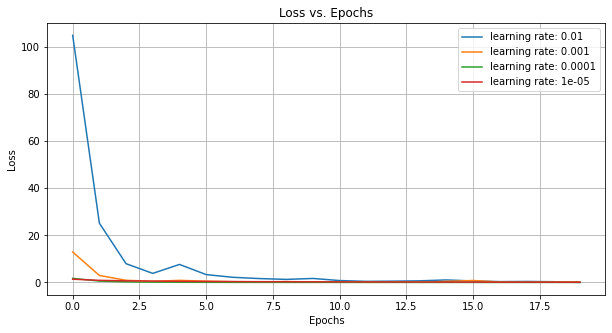

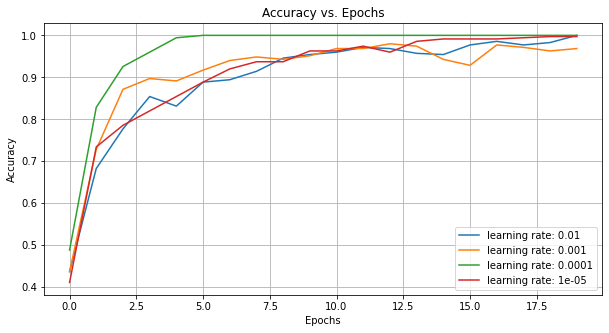

In [9]:
train_history = np.load('Outputs/models/train_history.npy', allow_pickle=True).item()
losses = train_history['loss']
accuracies = train_history['accuracy']

#plot the losses and accuracies
plot_loss(losses, learning_rates)
plot_accuracy(accuracies, learning_rates)